In [1]:
import os 
import torch 
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

In [2]:
def visualize_mesh(pos,face):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([])
    ax.plot_trisurf(pos[:,0],pos[:,1],pos[:,2],triangles=face.t(),antialiased=False)
    plt.show()

In [3]:
def visualize_points(pos,edge_index=None, index=None):
    fig = plt.figure(figsize=(4,4))
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():
            src = pos[src].tolist()
            dst = pos[dst].tolist()
            plt.plot([src[0], dst[0]], [src[1],dst[1]], linewidth=1, color='black')
    if index is None:
        plt.scatter(pos[:,0], pos[:,1], s=50, zorder=1000)
    else:
        mask = torch.zeros(pos.size(0), dtype=torch.bool)
        mask[index] = True
        plt.scatter(pos[~mask,0],pos[~mask,1], s=50, color='lightgray', zorder=1000)
        plt.scatter(pos[mask,0], pos[mask,1], s=50, zorder=1000)
    plt.axis('off')
    plt.show()

### Point Cloud classification with GNN

Extracting ..\datasets\GeometricShapes\raw.zip
Processing...


GeometricShapes(40)
Data(pos=[32, 3], face=[3, 30], y=[1])


Done!


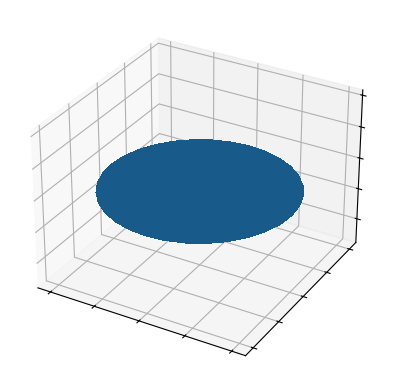

Data(pos=[4, 3], face=[3, 2], y=[1])


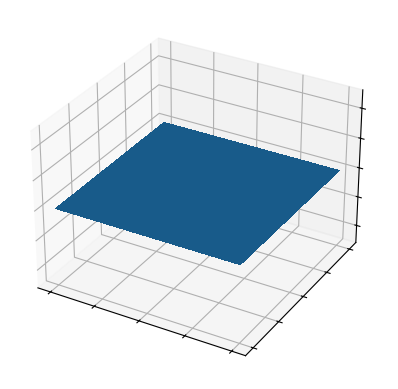

In [4]:
# DATA HANDLING: 40 2d, 3d geometries - cubes, spheres, pyramids

from torch_geometric.datasets import GeometricShapes

dataset = GeometricShapes(root='../datasets/GeometricShapes')
print(dataset)

data = dataset[0]
print(data)
# print(data.face)  
visualize_mesh(data.pos, data.face)

data = dataset[4]
print(data)
visualize_mesh(data.pos, data.face)
# print(data.pos)
# print(data.face) # the triangular face points are computed in the anti-clock wise based on the node/point numbers

## Point cloud generation

Data(pos=[256, 3], y=[1])
None


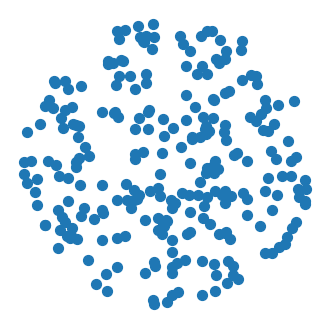

Data(pos=[256, 3], y=[1])
None


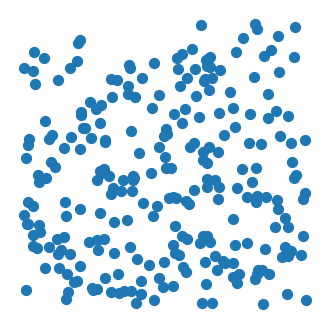

In [5]:
import torch 
from torch_geometric.transforms import SamplePoints

torch.manual_seed(42)

# convert original mesh object to point cloud using "SamplePoints" transform
dataset.transform = SamplePoints(num=256)

data = dataset[0]
print(data)
print(data.edge_index)
visualize_points(data.pos, data.edge_index)

data = dataset[4]
print(data)
print(data.edge_index)
visualize_points(data.pos, data.edge_index)

## PointNet++ : point cloud classification/segmentation via GNNs

- Processes point clouds iteratively via simple grouping, neightborhood aggregration, and downsampling scheme

1. grouping phase: constructs a graph to connect nearby points via either k-nearest neighbor search or ball queries (connect all points within a radius)
2. neighborhood aggregation phase: GNN layer aggregrates information from its direct neighbors
3. downsampling phase: implements pooling scheme 

torch.Size([2, 1536])


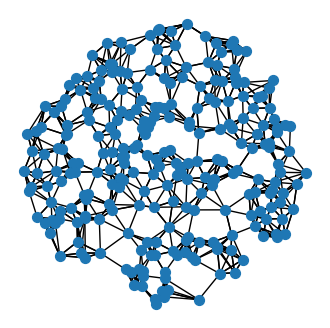

torch.Size([2, 1536])


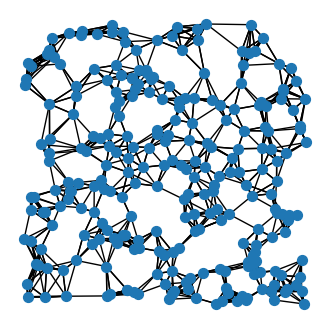

In [6]:
# Phase 1: grouping via dynamic graph generation
# "torch_cluster" for dynamic graph generation: knn_graph or radius_graph
# knn_graph outputs the edge_index of the graph constructed

from torch_cluster import knn_graph

data = dataset[0]
data.edge_index = knn_graph(data.pos, k=6) 
print(data.edge_index.shape)
visualize_points(data.pos, edge_index=data.edge_index)

data = dataset[4]
data.edge_index = knn_graph(data.pos, k=6)
print(data.edge_index.shape)
visualize_points(data.pos, edge_index=data.edge_index)

In [7]:
# Phase 2: Neighborhood aggregation: basically implement the Edge_conv from MessagePassing or below!

from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import MessagePassing

class PointNetLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='max')

        # initialize the MLP
        self.mlp = Sequential(Linear(in_channels + 3, out_channels),
                              ReLU(),
                              Linear(out_channels, out_channels))
    
    def forward(self,h,pos,edge_index):
        return self.propagate(edge_index, h=h, pos=pos) # first parameter should be edge_index

    def message(self, h_j, pos_j, pos_i):
        # h_j: neighboring node features [e, in_channels], **bug** shouldn't it be the current/central node (h_i) to concatenate to? 
        # p_j: neighboring node positions [e, 3]
        # p_i: central/current node positions [e,3]

        # message being passed from neighbor node "j" to central node "i"
        input = pos_j - pos_i # [num_edges/batch, num_features] [20480, 3]

        # **BUG**: In the message here, it should be h_i instead of h_j!
        if h_j is not None: # in 1st layer, the hidden node features might not be present (Investigate this?- could be, but not the case here!)
            input = torch.cat([h_j, input], dim=-1) # [num_edges/batch, 2 *num_features] [20480,6]
        
        return self.mlp(input) # [num_edges/batch, out_channels] [20480,32]
    

In [8]:
## Network architecture 

import torch 
# import torch.nn.functional as F
from torch_cluster import knn_graph 
from torch_geometric.nn import global_max_pool

class PointNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        torch.manual_seed(12345)
        self.conv1 = PointNetLayer(3,32)
        self.conv2 = PointNetLayer(32,32)
        self.classifier = Linear(32,dataset.num_classes)
    
    def forward(self, pos, batch):
        # compute the KNN graph: incl. self loops!!
        edge_index = knn_graph(pos,k=16,batch=batch,loop=True) # combined edge_index for all graphs in a batch
        # print(edge_index.shape) [20480,32] 

        # message passing -> aggregation (max) and thus reduces from [20480,32] -> [1280,32]
        h = self.conv1(h=pos, pos=pos, edge_index=edge_index) # [1280,32] [num_nodes, hidden_channels]
        h = h.relu()
        h = self.conv2(h=h, pos=pos, edge_index=edge_index) # [1280,32] [num_nodes, hidden_channels]
        h = h.relu() 

        # global pooling 
        h = global_max_pool(h,batch) # [10, 32] [num_examples in batch, hidden_channels] 

        # classifier
        return self.classifier(h) # [num_examples/batch, num_classes] [10, 40]

model = PointNet()
print(model)

PointNet(
  (conv1): PointNetLayer()
  (conv2): PointNetLayer()
  (classifier): Linear(in_features=32, out_features=40, bias=True)
)


In [9]:
# Train loop

from torch_geometric.loader import DataLoader
from torch_geometric.transforms import SamplePoints

train_dataset = GeometricShapes(root='../dataset/GeometricShapes', train=True, transform=SamplePoints(128))
test_dataset = GeometricShapes(root='../datasets/GeometricShapes', train=False, transform=SamplePoints(128))
# print(len(train_dataset), len(test_dataset))
# print(train_dataset[0], test_dataset[0])

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10)
# print(len(train_loader), len(test_loader))
# print(len(train_loader.dataset))
# print()

model = PointNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train(model,optimizer,loader):
    model.train()

    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        logits = model(data.pos, data.batch)
        loss = criterion(logits,data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()* data.num_graphs
    
    return total_loss/len(train_loader.dataset)

@torch.no_grad()
def test(model, loader):
    model.eval()

    total_correct=0
    for data in loader:
        logits = model(data.pos, data.batch)
        pred = logits.argmax(dim=1)
        total_correct += int((pred == data.y).sum())

    return total_correct/len(loader.dataset)

for epoch in range(1,5):
    loss = train(model,optimizer,train_loader)
    test_acc = test(model, test_loader)
    print(f'Epoch: {epoch:02d}, Train loss: {loss:.4f}, test acc: {test_acc:.4f}')

Epoch: 01, Train loss: nan, test acc: 0.0250
Epoch: 02, Train loss: nan, test acc: 0.0250
Epoch: 03, Train loss: nan, test acc: 0.0250
Epoch: 04, Train loss: nan, test acc: 0.0250


### Creating Message Passing Networks 
- https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_gnn.html

The message passing base class has following methods:

1. MessagePassing()
2. MessagePassing.propagate()
3. MessagePassing.message()
4. MessagePassing.update()

#### 1. Implement the GCN Layer 

- To Do: Look within propagate layer: message(), aggregate(), and update() functions

In [10]:
# Implementing the GCN Layer 
# Note 1: degree refers to # edges connected to the current node. 
# Note 2: feature values of neighboring nodes are divided by their degree during aggregation. degree-based normalization helps prevent nodes with more connections
# disproportionately influence the aggregared feature values   
# Note 3: Parameter() wrapping enables a tensor to be treated as a trainable parameter in a NN module

# 1. Add self-loops to the adjacency matrix.
# 2. Linearly transform node feature matrix.
# 3. Compute normalization coefficients.
# 4. Normalize node features in 
# 5. Sum up neighboring node features ("add" aggregation).
# 6. Apply a final bias vector.

import torch 
from torch.nn import Linear, Parameter 
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCNConv(MessagePassing): # MessagePassing is Superclass or Base Class here; GCNConv is the Subclass or Derived Class here! 
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters() # re-initialize trainable parameters

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_() # make the bias para zeros
    
    def forward(self,x,edge_index):
        
        # 1. add self loops
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # 2. linear transform 
        x = self.lin(x) # computes W.T . x_j in GCN layer

        # 3. normalization: compute norm for self_loops and undirected edges
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype) # gives degree of each node as per the node numbering
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # 4-5: propagate: internally calls message(), aggregate(), and update()
        out = self.propagate(edge_index, x=x, norm=norm)

        # 6. bias 
        out = out + self.bias 

        return out 

    def message(self, x_j, norm): # x_j [e, out_channels] - corresponds to source nodes; output from step 2. 
        return norm.view(-1,1) * x_j # multiplies source node linear transformed features with corresponding norms (source -> dest) 

    def update(self,aggr_out,x):
        return aggr_out + x # adding central node feature values in addition to self loops for each node above

In [11]:
import torch 
from torch_geometric.data import Data 

edge_index = torch.tensor([[0,1],
                           [1,0],
                           [1,2],
                           [2,1]], dtype=torch.long)

x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous())

conv = GCNConv(1,1)
x = conv(data.x, data.edge_index)

### 2. Implementing the edge convolution

In [16]:
import torch 
from torch.nn import Sequential as Seq, Linear, ReLU
from torch_geometric.nn import MessagePassing

class EdgeConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='max')
        # self.mlp = Seq(Linear(2*in_channels, out_channels),
                            #   ReLU(),
                            #   Linear(out_channels, out_channels))
    
    def forward(self, x, edge_index):
        # x [n, in_channels]
        return self.propagate(edge_index,x=x)

    # Note: when computing message: e_ji where j is the source and i is the target. 
    # we are computing message to be passed from j -> i and aggregated at i for that node
    def message(self,x_i,x_j): 
        # x_i & x_j shape: [e, in_channels]
        print('xi',x_i)
        print('xj',x_j)
        temp = torch.cat([x_i,x_j-x_i],dim=1)
        # return self.mlp(temp)
        print(temp)
        return temp

In [18]:
import torch 
from torch_geometric.data import Data 

edge_index = torch.tensor([[0,1],
                           [1,0],
                           [1,2],
                           [2,1]], dtype=torch.long)

x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous())

print(data.x)
print(data.edge_index)

conv = EdgeConv(1,1)
x = conv(data.x, data.edge_index)
x # rmb it's max aggregate

tensor([[-1.],
        [ 0.],
        [ 1.]])
tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])
xi tensor([[ 0.],
        [-1.],
        [ 1.],
        [ 0.]])
xj tensor([[-1.],
        [ 0.],
        [ 0.],
        [ 1.]])
tensor([[ 0., -1.],
        [-1.,  1.],
        [ 1., -1.],
        [ 0.,  1.]])


tensor([[-1.,  1.],
        [ 0.,  1.],
        [ 1., -1.]])